In [1]:
%matplotlib inline

import os, csv, itertools
from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 输出图片目录
if not os.path.exists("output"):
    os.mkdir("output")


X shape: (738, 2)
y shape: (738,)
classes: [0 1 2 3]


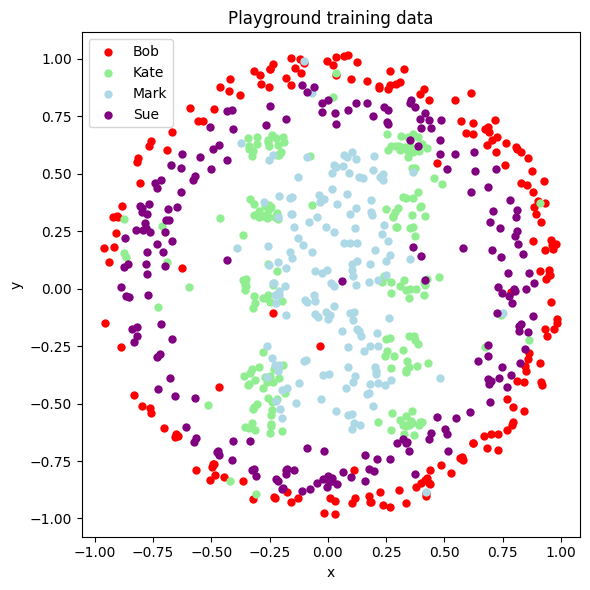

In [3]:
# 读取 train.csv 并可视化

file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)  # 跳过表头

X = np.ndarray((0, 2))
y = np.ndarray((0,))

# 把人名映射成数字标签
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}

for row in reader:
    # row: [x, y, name]
    X = np.vstack((X, np.array(row[0:2], dtype=float)))
    y = np.append(y, y_mapping[row[2]])

file.close()

y = y.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("classes:", np.unique(y))

plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob',  c='red',        linewidths=0)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue',  linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue',  c='purple',     linewidths=0)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Playground training data')
plt.tight_layout()
plt.savefig('./output/fig-train-scatter.png', dpi=300)
plt.show()


In [4]:
# 划分训练集&测试集

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test  size:", X_test.shape[0])


Train size: 590
Test  size: 148


In [5]:
# 定义评估函数，跑几个单模型

results = []

def evaluate_model(name, pipeline, param_grid):
    """
    用 GridSearchCV + 5-fold CV 调参，然后在独立测试集上评估。
    """
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)
    print(f'[{name}] best CV accuracy = {gs.best_score_:.3f}')
    print('  best params:', gs.best_params_)
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    print(f'  test accuracy = {acc_test:.3f}\n')
    results.append({'model': name,
                    'cv_acc': gs.best_score_,
                    'test_acc': acc_test})
    return best_model

# 1) Logistic Regression
pipe_lr = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])
param_lr = {
    'clf__C': [0.1, 1.0, 10.0, 100.0]
}
best_lr = evaluate_model('LogisticRegression', pipe_lr, param_lr)

# 2) KNN
pipe_knn_base = Pipeline([
    ('sc', StandardScaler()),
    ('clf', KNeighborsClassifier())
])
param_knn = {
    'clf__n_neighbors': [3, 5, 7, 9]
}
best_knn = evaluate_model('KNN', pipe_knn_base, param_knn)

# 3) Decision Tree
pipe_dt = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=0))
])
param_dt = {
    'clf__max_depth': [1, 3, 5, None],
    'clf__criterion': ['gini', 'entropy']
}
best_dt = evaluate_model('DecisionTree', pipe_dt, param_dt)

# 4) RBF SVM
pipe_svm = Pipeline([
    ('sc', StandardScaler()),
    ('clf', SVC(kernel='rbf'))
])
param_svm = {
    'clf__C': [0.5, 1.0, 2.0, 5.0],
    'clf__gamma': [0.1, 0.5, 1.0]
}
best_svm = evaluate_model('RBF SVM', pipe_svm, param_svm)


[LogisticRegression] best CV accuracy = 0.263
  best params: {'clf__C': 0.1}
  test accuracy = 0.318

[KNN] best CV accuracy = 0.820
  best params: {'clf__n_neighbors': 3}
  test accuracy = 0.851

[DecisionTree] best CV accuracy = 0.781
  best params: {'clf__criterion': 'entropy', 'clf__max_depth': None}
  test accuracy = 0.791

[RBF SVM] best CV accuracy = 0.846
  best params: {'clf__C': 5.0, 'clf__gamma': 0.5}
  test accuracy = 0.824



In [6]:
# Voting 集成

# 使用上面调好超参数的三个基学习器：Logistic + DecisionTree + KNN
voting_clf = VotingClassifier(
    estimators=[
        ('lr',  best_lr),
        ('dt',  best_dt),
        ('knn', best_knn)
    ],
    voting='soft'
)

# 用 GridSearch 简单扫一些权重组合
param_voting = {
    'weights': [
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [2, 2, 1]
    ]
}

gs_voting = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_voting,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
gs_voting.fit(X_train, y_train)

print('[Voting] best CV accuracy = %.3f' % gs_voting.best_score_)
print('  best params:', gs_voting.best_params_)
voting_best = gs_voting.best_estimator_
y_pred_vote = voting_best.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred_vote)
print('  test accuracy = %.3f\n' % acc_vote)

results.append({'model': 'Voting',
                'cv_acc': gs_voting.best_score_,
                'test_acc': acc_vote})


[Voting] best CV accuracy = 0.812
  best params: {'weights': [1, 1, 2]}
  test accuracy = 0.831



In [7]:
# Bagging 集成

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=0),
    n_estimators=200,
    max_samples=0.7,
    bootstrap=True,
    n_jobs=-1,
    random_state=1
)

param_bag = {
    'n_estimators': [100, 200, 500],
    'max_samples':  [0.5, 0.7, 1.0]
}

gs_bag = GridSearchCV(
    estimator=bag,
    param_grid=param_bag,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
gs_bag.fit(X_train, y_train)

print('[Bagging] best CV accuracy = %.3f' % gs_bag.best_score_)
print('  best params:', gs_bag.best_params_)
bag_best = gs_bag.best_estimator_
y_pred_bag = bag_best.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
print('  test accuracy = %.3f\n' % acc_bag)

results.append({'model': 'Bagging',
                'cv_acc': gs_bag.best_score_,
                'test_acc': acc_bag})


[Bagging] best CV accuracy = 0.820
  best params: {'max_samples': 0.5, 'n_estimators': 200}
  test accuracy = 0.838



In [8]:
# AdaBoost 提升法
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='entropy',
        max_depth=1,
        random_state=0
    ),
    n_estimators=200,
    learning_rate=1.0,
    random_state=1
)


param_ada = {
    'estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.5, 1.0]
}

gs_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_ada,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
gs_ada.fit(X_train, y_train)

print('[AdaBoost] best CV accuracy = %.3f' % gs_ada.best_score_)
print('  best params:', gs_ada.best_params_)
ada_best = gs_ada.best_estimator_
y_pred_ada = ada_best.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)
print('  test accuracy = %.3f\n' % acc_ada)

results.append({'model': 'AdaBoost',
                'cv_acc': gs_ada.best_score_,
                'test_acc': acc_ada})


[AdaBoost] best CV accuracy = 0.780
  best params: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 50}
  test accuracy = 0.784



In [9]:
# 汇总所有模型的CV

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_acc', ascending=False)
display(results_df)

best_row = results_df.iloc[0]
print("Best model on our hold-out test set:",
      best_row['model'],
      "(test accuracy = %.3f)" % best_row['test_acc'])


,model,cv_acc,test_acc
1,KNN,0.820339,0.851351
5,Bagging,0.820339,0.837838
4,Voting,0.811864,0.831081
3,RBF SVM,0.845763,0.824324
2,DecisionTree,0.781356,0.790541
6,AdaBoost,0.779661,0.783784
0,LogisticRegression,0.262712,0.317568


Best model on our hold-out test set: KNN (test accuracy = 0.851)
